In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
import math
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
import seaborn as sns

In [2]:
amount_features = ["DEBITOR_AMOUNT"]
age_synthetic_features = ["DEBITOR_ACCOUNT_AGE"]#, "CREDITOR_ACCOUNT_AGE"]
lat_long_synthetic_features = ["DEBITOR_PHY_AND_TOWER_DISTANCE", "CREDITOR_PHY_AND_TOWER_DISTANCE"]

all_data_features = [
    "FRAUD_FLAG",
    "DEBITOR_AMOUNT",
    "DEBITOR_GEO_LATITUDE", "DEBITOR_GEO_LONGITUDE",
    "DEBITOR_TOWER_LATITUDE", "DEBITOR_TOWER_LONGITUDE",
    "CREDITOR_GEO_LATITUDE", "CREDITOR_GEO_LONGITUDE",
    "CREDITOR_TOWER_LATITUDE", "CREDITOR_TOWER_LONGITUDE",
    "DEBITOR_ACCOUNT_CREATE_TIMESTAMP", "CREDITOR_ACCOUNT_CREATE_TIMESTAMP",
]
all_model_parameters = lat_long_synthetic_features + amount_features + age_synthetic_features
flag = "FRAUD_FLAG"

print("Data Features: ", all_data_features, "\nModel Features: ", all_model_parameters, "\nFlag: ", flag)

Data Features:  ['FRAUD_FLAG', 'DEBITOR_AMOUNT', 'DEBITOR_GEO_LATITUDE', 'DEBITOR_GEO_LONGITUDE', 'DEBITOR_TOWER_LATITUDE', 'DEBITOR_TOWER_LONGITUDE', 'CREDITOR_GEO_LATITUDE', 'CREDITOR_GEO_LONGITUDE', 'CREDITOR_TOWER_LATITUDE', 'CREDITOR_TOWER_LONGITUDE', 'DEBITOR_ACCOUNT_CREATE_TIMESTAMP', 'CREDITOR_ACCOUNT_CREATE_TIMESTAMP'] 
Model Features:  ['DEBITOR_PHY_AND_TOWER_DISTANCE', 'CREDITOR_PHY_AND_TOWER_DISTANCE', 'DEBITOR_AMOUNT', 'DEBITOR_ACCOUNT_AGE'] 
Flag:  FRAUD_FLAG


In [3]:
def convert_flag_to_1_0(dataset: pd.DataFrame) -> pd.DataFrame:
    dataset[flag] = dataset[flag].astype(np.int64)
    return dataset


def combine_and_convert_date_fields_to_age(dataset: pd.DataFrame, age_field: str, fields: list) -> pd.DataFrame:
    dataset.loc[:, age_field] = dataset.loc[:, fields].apply(
        lambda row: (date.today() - date(row.iloc[0], row.iloc[1], row.iloc[2])).days, axis=1
    )
    return dataset


def convert_timestamp_field_to_age(dataset: pd.DataFrame, timestamp_field: str, fields: str) -> pd.DataFrame:
    dataset.loc[:, timestamp_field] = dataset.loc[:, fields].apply(
        lambda ts: ((datetime.today() - datetime.fromtimestamp(ts)).total_seconds() / 86400)
    )
    return dataset

def find_transaction_time_since_creation(dataset: pd.DataFrame, timestamp_field: str, fields: list)  -> pd.DataFrame:
    dataset.loc[:, timestamp_field] = dataset.loc[:, fields].apply(
        lambda ts: (datetime.fromtimestamp(ts.iloc[1]) - datetime.fromtimestamp(ts.iloc[0])).total_seconds()/60, axis=1
    )
    return dataset
def get_distance_from_lat_long(dataset: pd.DataFrame, distance_field: str, fields: list) -> pd.DataFrame:
    def calculate_geodesic_distance(lat1, lon1, lat2, lon2) -> np.float32:
        # https://stackoverflow.com/a/19412565
        earth_radius = 3958.8 * 1.6  # in km
        lat1 = math.radians(lat1)
        lon1 = math.radians(lon1)
        lat2 = math.radians(lat2)
        lon2 = math.radians(lon2)
        lat_dist = lat2 - lat1
        lon_dist = lon2 - lon1
        a = math.sin(lat_dist / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(lon_dist / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = earth_radius * c
        return np.float64(distance)

    dataset.loc[:, distance_field] = dataset.loc[:, fields].apply(
        lambda row: calculate_geodesic_distance(row.iloc[0], row.iloc[1], row.iloc[2], row.iloc[3]), axis=1
    )
    return dataset


def scale_data(df: pd.DataFrame, scaler) -> pd.DataFrame:
    
    return scaler.transform(df)
    # return StandardScaler().fit_transform(df)


def prepare_dataset(dataset: pd.DataFrame, scaler = None) -> pd.DataFrame:
    # combine debitor and creditor birth Y/M/D params to create a synthetic age parameters
    dataset = combine_and_convert_date_fields_to_age(
        dataset, "DEBITOR_AGE",
        ["DEBITOR_BIRTH_YEAR", "DEBITOR_BIRTH_MONTH", "DEBITOR_BIRTH_DAY"])
    dataset = combine_and_convert_date_fields_to_age(
        dataset, "CREDITOR_AGE",
        ["CREDITOR_BIRTH_YEAR", "CREDITOR_BIRTH_MONTH", "CREDITOR_BIRTH_DAY"])
    # parse and create a debitor and creditor account age virtual parameter  in seconds from account create timestamp
    # dataset = convert_timestamp_field_to_age(
    #     dataset, "DEBITOR_ACCOUNT_AGE",
    #     "DEBITOR_ACCOUNT_CREATE_TIMESTAMP", 
    # )
    dataset = find_transaction_time_since_creation(
        dataset, "DEBITOR_ACCOUNT_AGE",
        ["DEBITOR_ACCOUNT_CREATE_TIMESTAMP", "PAYMENT_INIT_TIMESTAMP"]
    )
    dataset = find_transaction_time_since_creation(
        dataset, "CREDITOR_ACCOUNT_AGE",
        ["CREDITOR_ACCOUNT_CREATE_TIMESTAMP","PAYMENT_INIT_TIMESTAMP"]
    )
    dataset = get_distance_from_lat_long(
        dataset, "DEBITOR_PHY_AND_TOWER_DISTANCE",
        ["DEBITOR_GEO_LATITUDE", "DEBITOR_GEO_LONGITUDE", "DEBITOR_TOWER_LATITUDE", "DEBITOR_TOWER_LONGITUDE"]
    )
    dataset = get_distance_from_lat_long(
        dataset, "CREDITOR_PHY_AND_TOWER_DISTANCE",
        ["CREDITOR_GEO_LATITUDE", "CREDITOR_GEO_LONGITUDE", "CREDITOR_TOWER_LATITUDE", "CREDITOR_TOWER_LONGITUDE"]
    )
    dataset = convert_flag_to_1_0(dataset)

    
    # now all features should be numeric and unit-less. we can scale the data correctly now
    if scaler:
        dataset.loc[:, all_model_parameters] = scale_data(dataset.loc[:, all_model_parameters], scaler=scaler)
    return dataset


In [4]:
type_1_data_path = "sarthak_latest_data/bank1_[type1]_[app_frac_0.9]_[no_overlap]_[gen_train_1].csv"
type_1_data = pd.read_csv(type_1_data_path)
type_1_data_processed = prepare_dataset(type_1_data)

In [5]:
type_2_data_path = "sarthak_latest_data/bank2_[type2]_[app_frac_0.9]_[no_overlap]_[gen_train_1].csv"
type_2_data = pd.read_csv(type_2_data_path)
type_2_data_processed = prepare_dataset(type_2_data)

In [6]:
# sns.reset_orig()
sns.set(rc={'figure.figsize': (30, 10)})

In [7]:
feat_label_map = {"DEBITOR_PHY_AND_TOWER_DISTANCE":"Dist. b/w IP and Physical location (Debtor)",
                    "CREDITOR_PHY_AND_TOWER_DISTANCE":"Dist. b/w IP and Physical location (Creditor)",
                    "DEBITOR_AMOUNT":"Amount of transaction",
                    "DEBITOR_ACCOUNT_AGE":"Age of Account"}
label_map = {0:"Non-fraudulent", 1:"Fraudulent"}

# Synthetic data analysis

/var/folders/dw/728p_t_d1lg65zgw2cp1gqhc0000gp/T/ipykernel_67948/4200575336.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


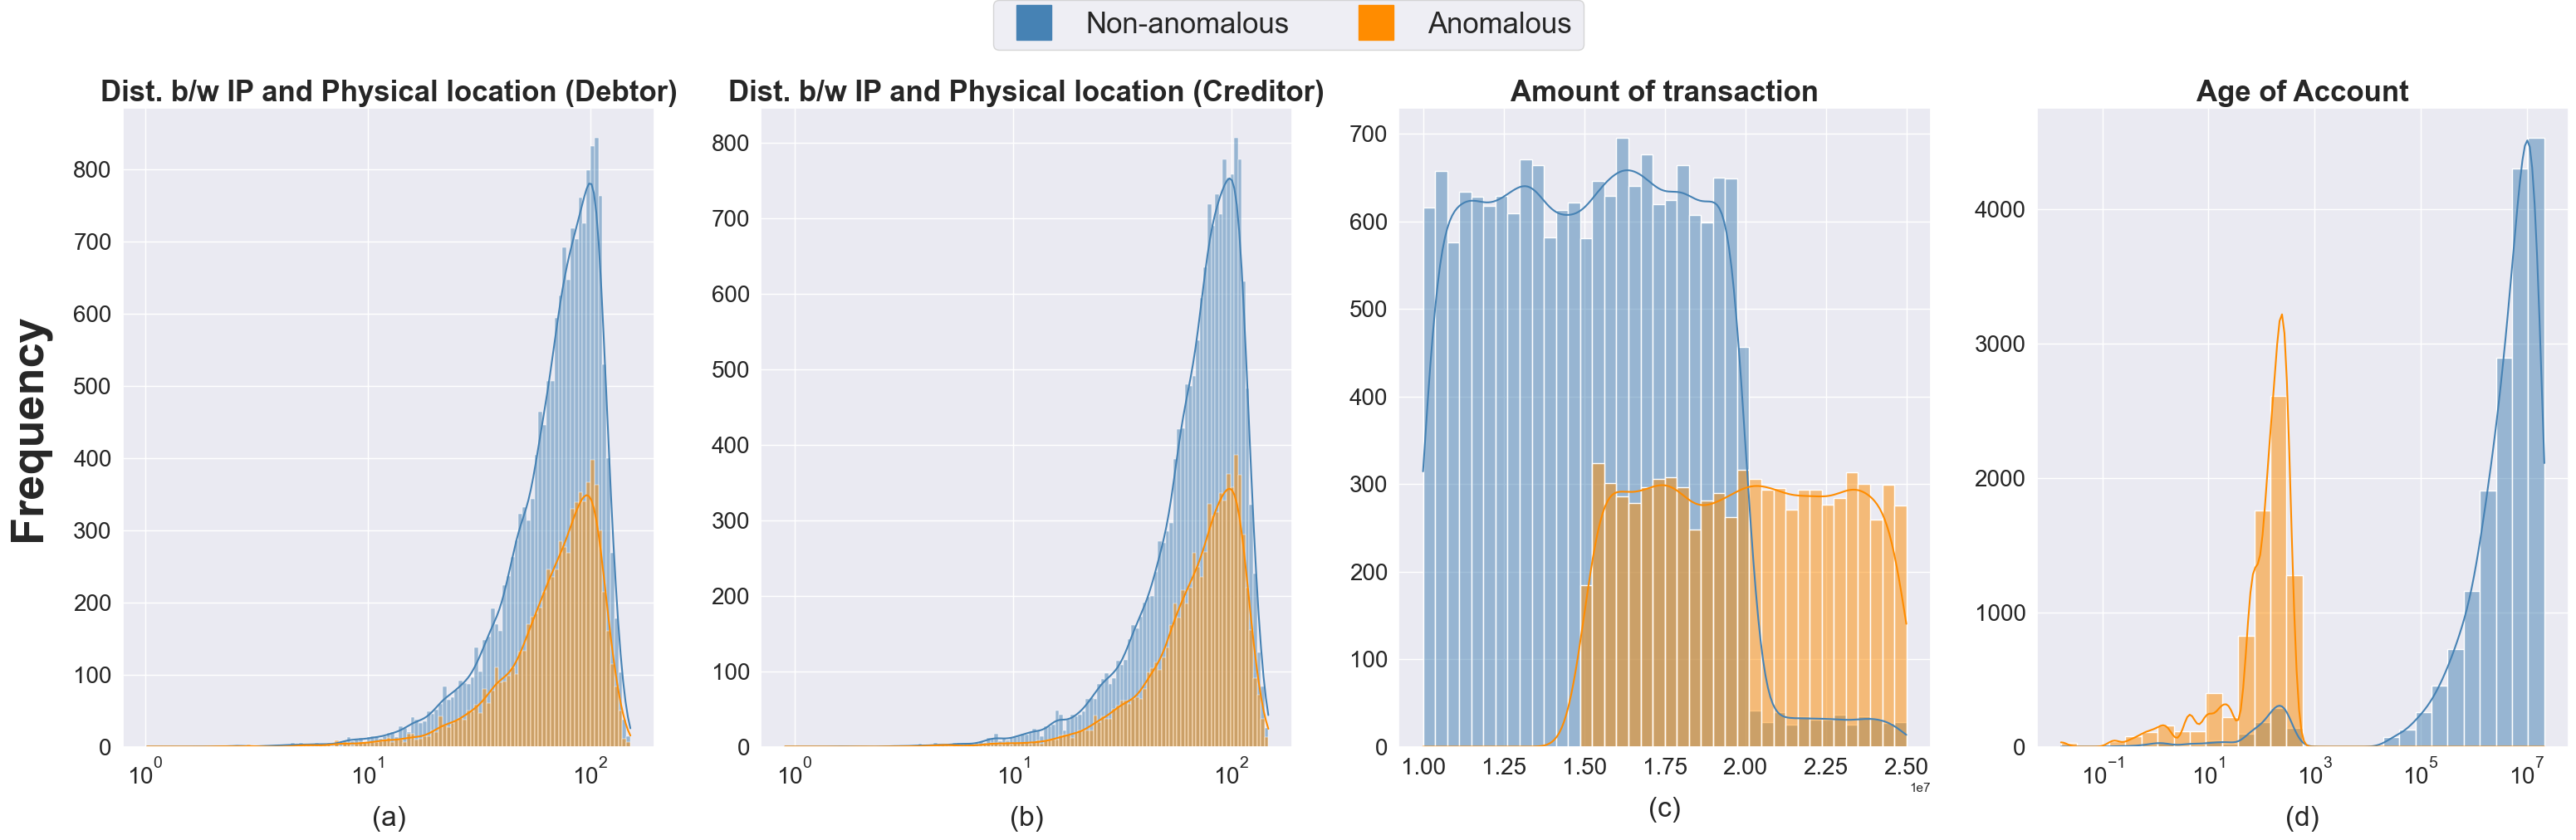

In [8]:
fig, axes = plt.subplots(ncols= 4, nrows=1,figsize=(38, 10))#, sharey="row")
axes = axes.flatten()
idx = 0
for i, feature in enumerate(all_model_parameters):

    # if j==0 and "DIST" in feature:
    #     filtered_data = remove_noisy_data(filtered_data, feature)
    # if j==0:
    #     p = "steelblue"
    # else:
    #     p = "darkorange"
    if "AGE" in feature or "DIST" in feature:
        sns.histplot(data=type_2_data_processed, x=feature, hue="FRAUD_FLAG", hue_order=[1,0],  ax=axes[idx], palette=['darkorange', 'steelblue'], kde=True, log_scale=True)
    else:
        sns.histplot(data=type_2_data_processed, x=feature, hue="FRAUD_FLAG", hue_order=[1,0], ax=axes[idx], palette=['darkorange', 'steelblue'], kde=True)#, log_scale="DIST" in feature)
    # if idx<4:
    #     axes[idx].set_title(label_map[j], fontsize=30)
    
    axes[idx].set_title(feat_label_map[feature], fontsize=25, fontweight="bold")
    # axes[idx].set_xlabel(feat_label_map[feature], fontsize=24, labelpad=20)
    axes[idx].set_xlabel("("+chr(97+i)+")", fontsize=24, labelpad=15)
    if i==0:
        axes[idx].set_ylabel("Frequency",fontsize=39, labelpad=20, fontweight="bold")
    else:
        axes[idx].set_ylabel("", fontsize=24, labelpad=30)
    # if "DIST" in feature:
    #     axes[idx].set_yticks([1000,2000,3000,4000])
    # axes[idx].set_xticks(fontsize=12)  # Increase x-axis tick label font size
    # axes[idx].set_yticks(fontsize=12)
    axes[idx].tick_params(labelsize=20)
    idx += 1
# plt.tight_layout()
# plt.savefig(fig, "temp.png")

line1 = plt.plot([], [], "steelblue", marker='s',markersize=30, ls="none", label='Non-anomalous')[0]
line2 = plt.plot([], [], "darkorange",marker='s', markersize=30, ls="none", label='Anomalous')[0]
fig.legend(handles=[line1, line2], loc="upper center", fontsize=25, ncol=2,borderaxespad=0)

# plt.subplots_adjust(hspace=0.3)
# Remove individual legends
for ax in axes:
  ax.legend().remove()
plt.savefig("sarthak_latest_data/type_2_data_dist_v2.png")

plt.show()


/var/folders/dw/728p_t_d1lg65zgw2cp1gqhc0000gp/T/ipykernel_67948/2239654204.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


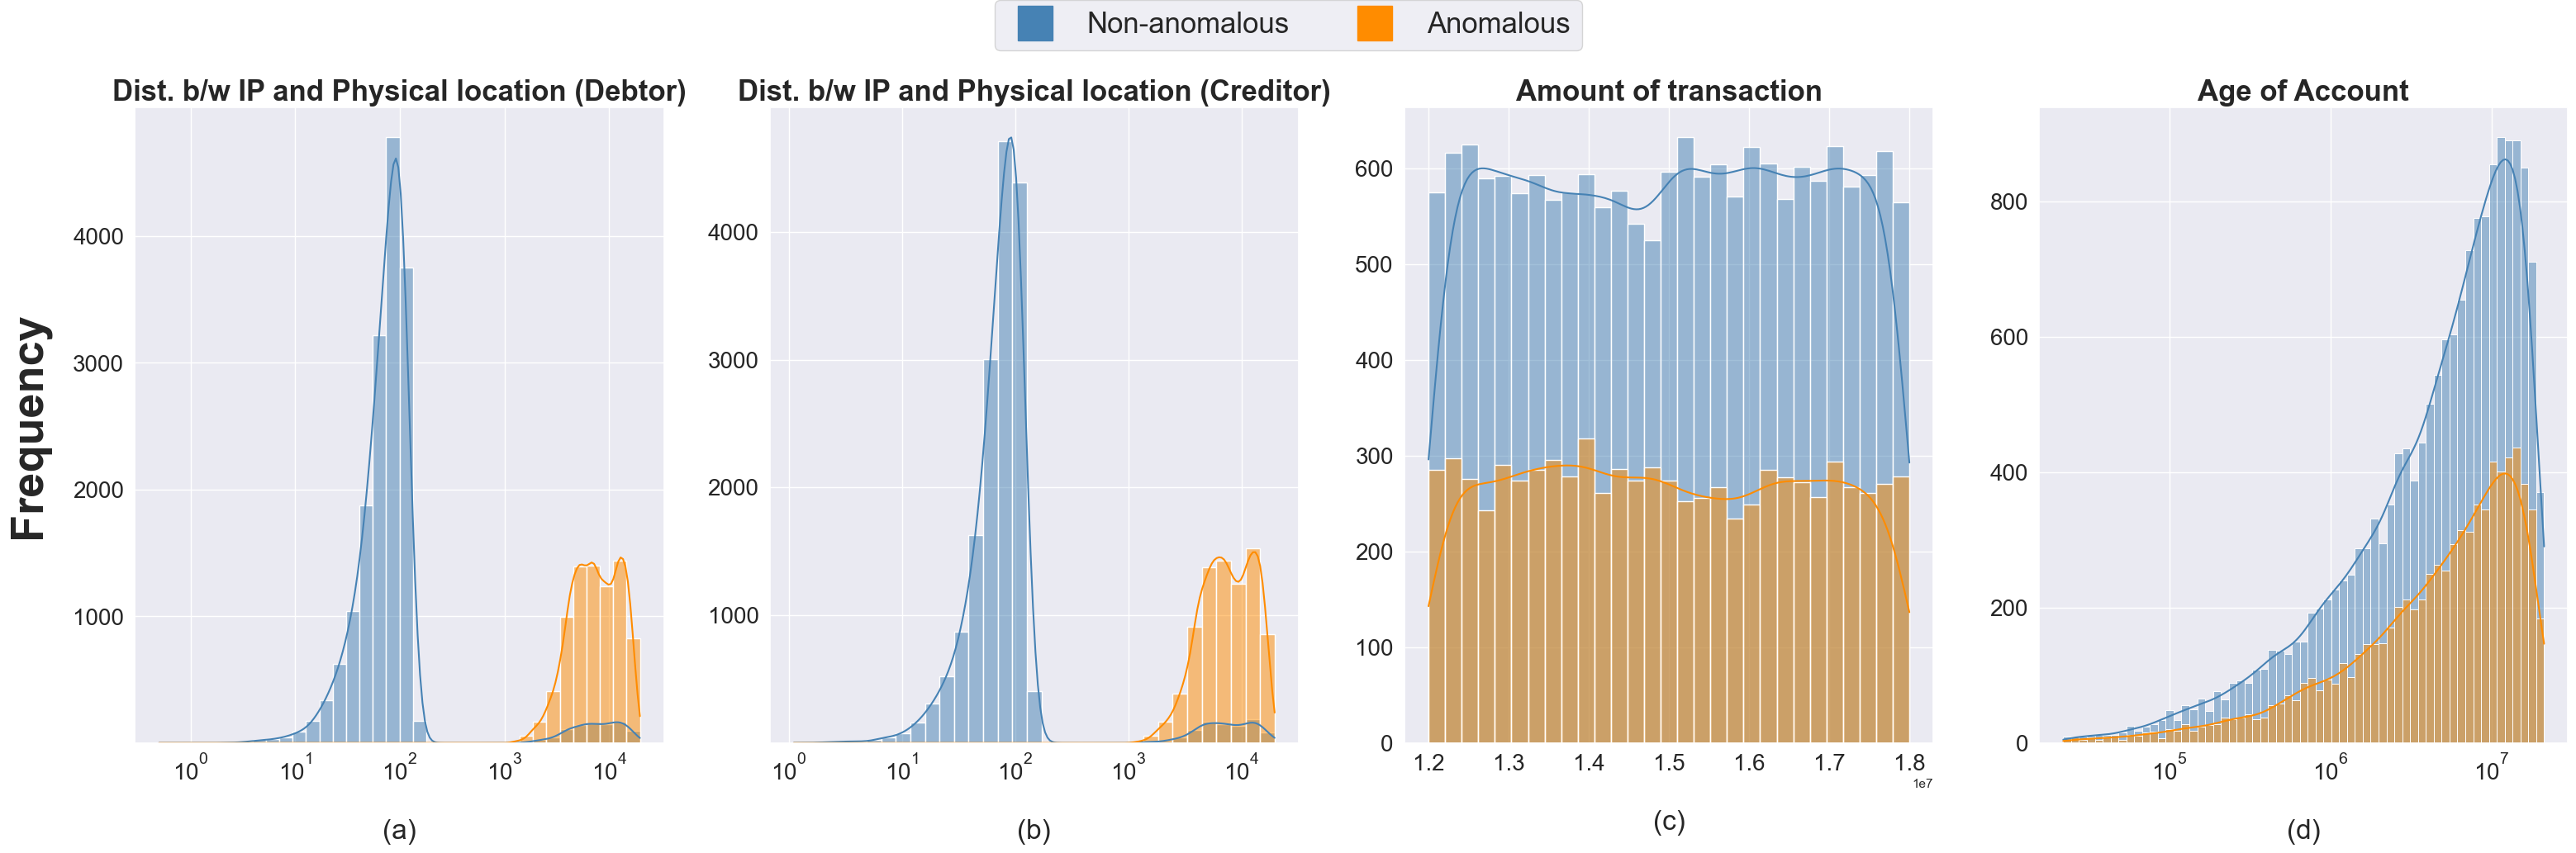

In [9]:
fig, axes = plt.subplots(ncols= 4, nrows=1,figsize=(38, 10))#, sharey="row")
axes = axes.flatten()
idx = 0
for i, feature in enumerate(all_model_parameters):

    # if j==0 and "DIST" in feature:
    #     filtered_data = remove_noisy_data(filtered_data, feature)
    # if j==0:
    #     p = "steelblue"
    # else:
    #     p = "darkorange"
    if "AGE" in feature or "DIST" in feature:
        sns.histplot(data=type_1_data_processed, x=feature, hue="FRAUD_FLAG", hue_order=[1,0],  ax=axes[idx], palette=['darkorange', 'steelblue'], kde=True, log_scale=True)
    else:
        sns.histplot(data=type_1_data_processed, x=feature, hue="FRAUD_FLAG", hue_order=[1,0], ax=axes[idx], palette=['darkorange', 'steelblue'], kde=True)#, log_scale="DIST" in feature)
    # if idx<4:
    #     axes[idx].set_title(label_map[j], fontsize=30)
    
    axes[idx].set_title(feat_label_map[feature], fontsize=25, fontweight="bold")
    # axes[idx].set_xlabel(feat_label_map[feature], fontsize=24, labelpad=20)
    axes[idx].set_xlabel("("+chr(97+i)+")", fontsize=24, labelpad=30)
    if i==0:
        axes[idx].set_ylabel("Frequency",fontsize=39, labelpad=20, fontweight="bold")
    else:
        axes[idx].set_ylabel("", fontsize=24, labelpad=30)
    if "DIST" in feature:
        axes[idx].set_yticks([1000,2000,3000,4000])
    # axes[idx].set_xticks(fontsize=12)  # Increase x-axis tick label font size
    # axes[idx].set_yticks(fontsize=12)
    axes[idx].tick_params(labelsize=20)
    idx += 1
# plt.tight_layout()
# plt.savefig(fig, "temp.png")

line1 = plt.plot([], [], "steelblue", marker='s',markersize=30, ls="none", label='Non-anomalous')[0]
line2 = plt.plot([], [], "darkorange",marker='s', markersize=30, ls="none", label='Anomalous')[0]
fig.legend(handles=[line1, line2], loc="upper center", fontsize=25, ncol=2,borderaxespad=0)

# plt.subplots_adjust(hspace=0.3)
# Remove individual legends
for ax in axes:
  ax.legend().remove()
# plt.savefig("type_1_data_dist.png")

plt.show()




# Model output plots

In [10]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import glob

In [11]:
def get_metrics(y_true, y_pred):
    p,r,f, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    accuracy = np.mean(y_true==y_pred)
    return p,r,f,accuracy

In [12]:
ui_to_round_map = {"before":0, "agg1":1, "agg2":2, "agg3":3, "agg4":4}
label_map = {"bank1": "Bank 1", "bank2":"Bank 2", "type1": "Location-based Anomaly", "type2":"Age-based Anomaly"}

In [13]:

model_results_dict = []
for file in  glob.glob("/Users/V822540/Downloads/onyx/aikya-material-shared/results-raw-data/*"):
    if "shap" in file:
        continue
    metadata = file.split("/")[-1][:-4].split("-")
    preds = pd.read_csv(file)
    assert len(preds)==2500
    p,r,f,acc = get_metrics(preds["actual"], preds["predicted"])
    model_results_dict.append({
            "bank": metadata[0],
            "eval": metadata[1],
            "precision":p,
            "recall" : r,
            "f1": f,
            "accuracy": acc,
            "round" : ui_to_round_map[metadata[2]]

            })

/Users/V822540/Downloads/onyx/fl_aikya/aikya-client/fed-learn-client-agent/fed_learn_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/V822540/Downloads/onyx/fl_aikya/aikya-client/fed-learn-client-agent/fed_learn_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/V822540/Downloads/onyx/fl_aikya/aikya-client/fed-learn-client-agent/fed_learn_env_2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set t

In [14]:
model_results = pd.DataFrame(model_results_dict).sort_values(["bank", "eval","round"])

In [15]:
model_results

,bank,eval,precision,recall,f1,accuracy,round
15,bank1,type1,0.900110,0.996355,0.945790,0.9624,0
12,bank1,type1,0.000000,0.000000,0.000000,0.6708,1
13,bank1,type1,0.903915,0.925881,0.914766,0.9432,2
14,bank1,type1,0.900901,0.972053,0.935126,0.9556,3
11,bank1,type1,0.899554,0.979344,0.937755,0.9572,4
10,bank1,type2,0.000000,0.000000,0.000000,0.6600,0
2,bank1,type2,0.000000,0.000000,0.000000,0.6600,1
0,bank1,type2,0.891228,0.298824,0.447577,0.7492,2
1,bank1,type2,0.902273,0.934118,0.917919,0.9432,3
3,bank1,type2,0.899894,0.994118,0.944662,0.9604,4


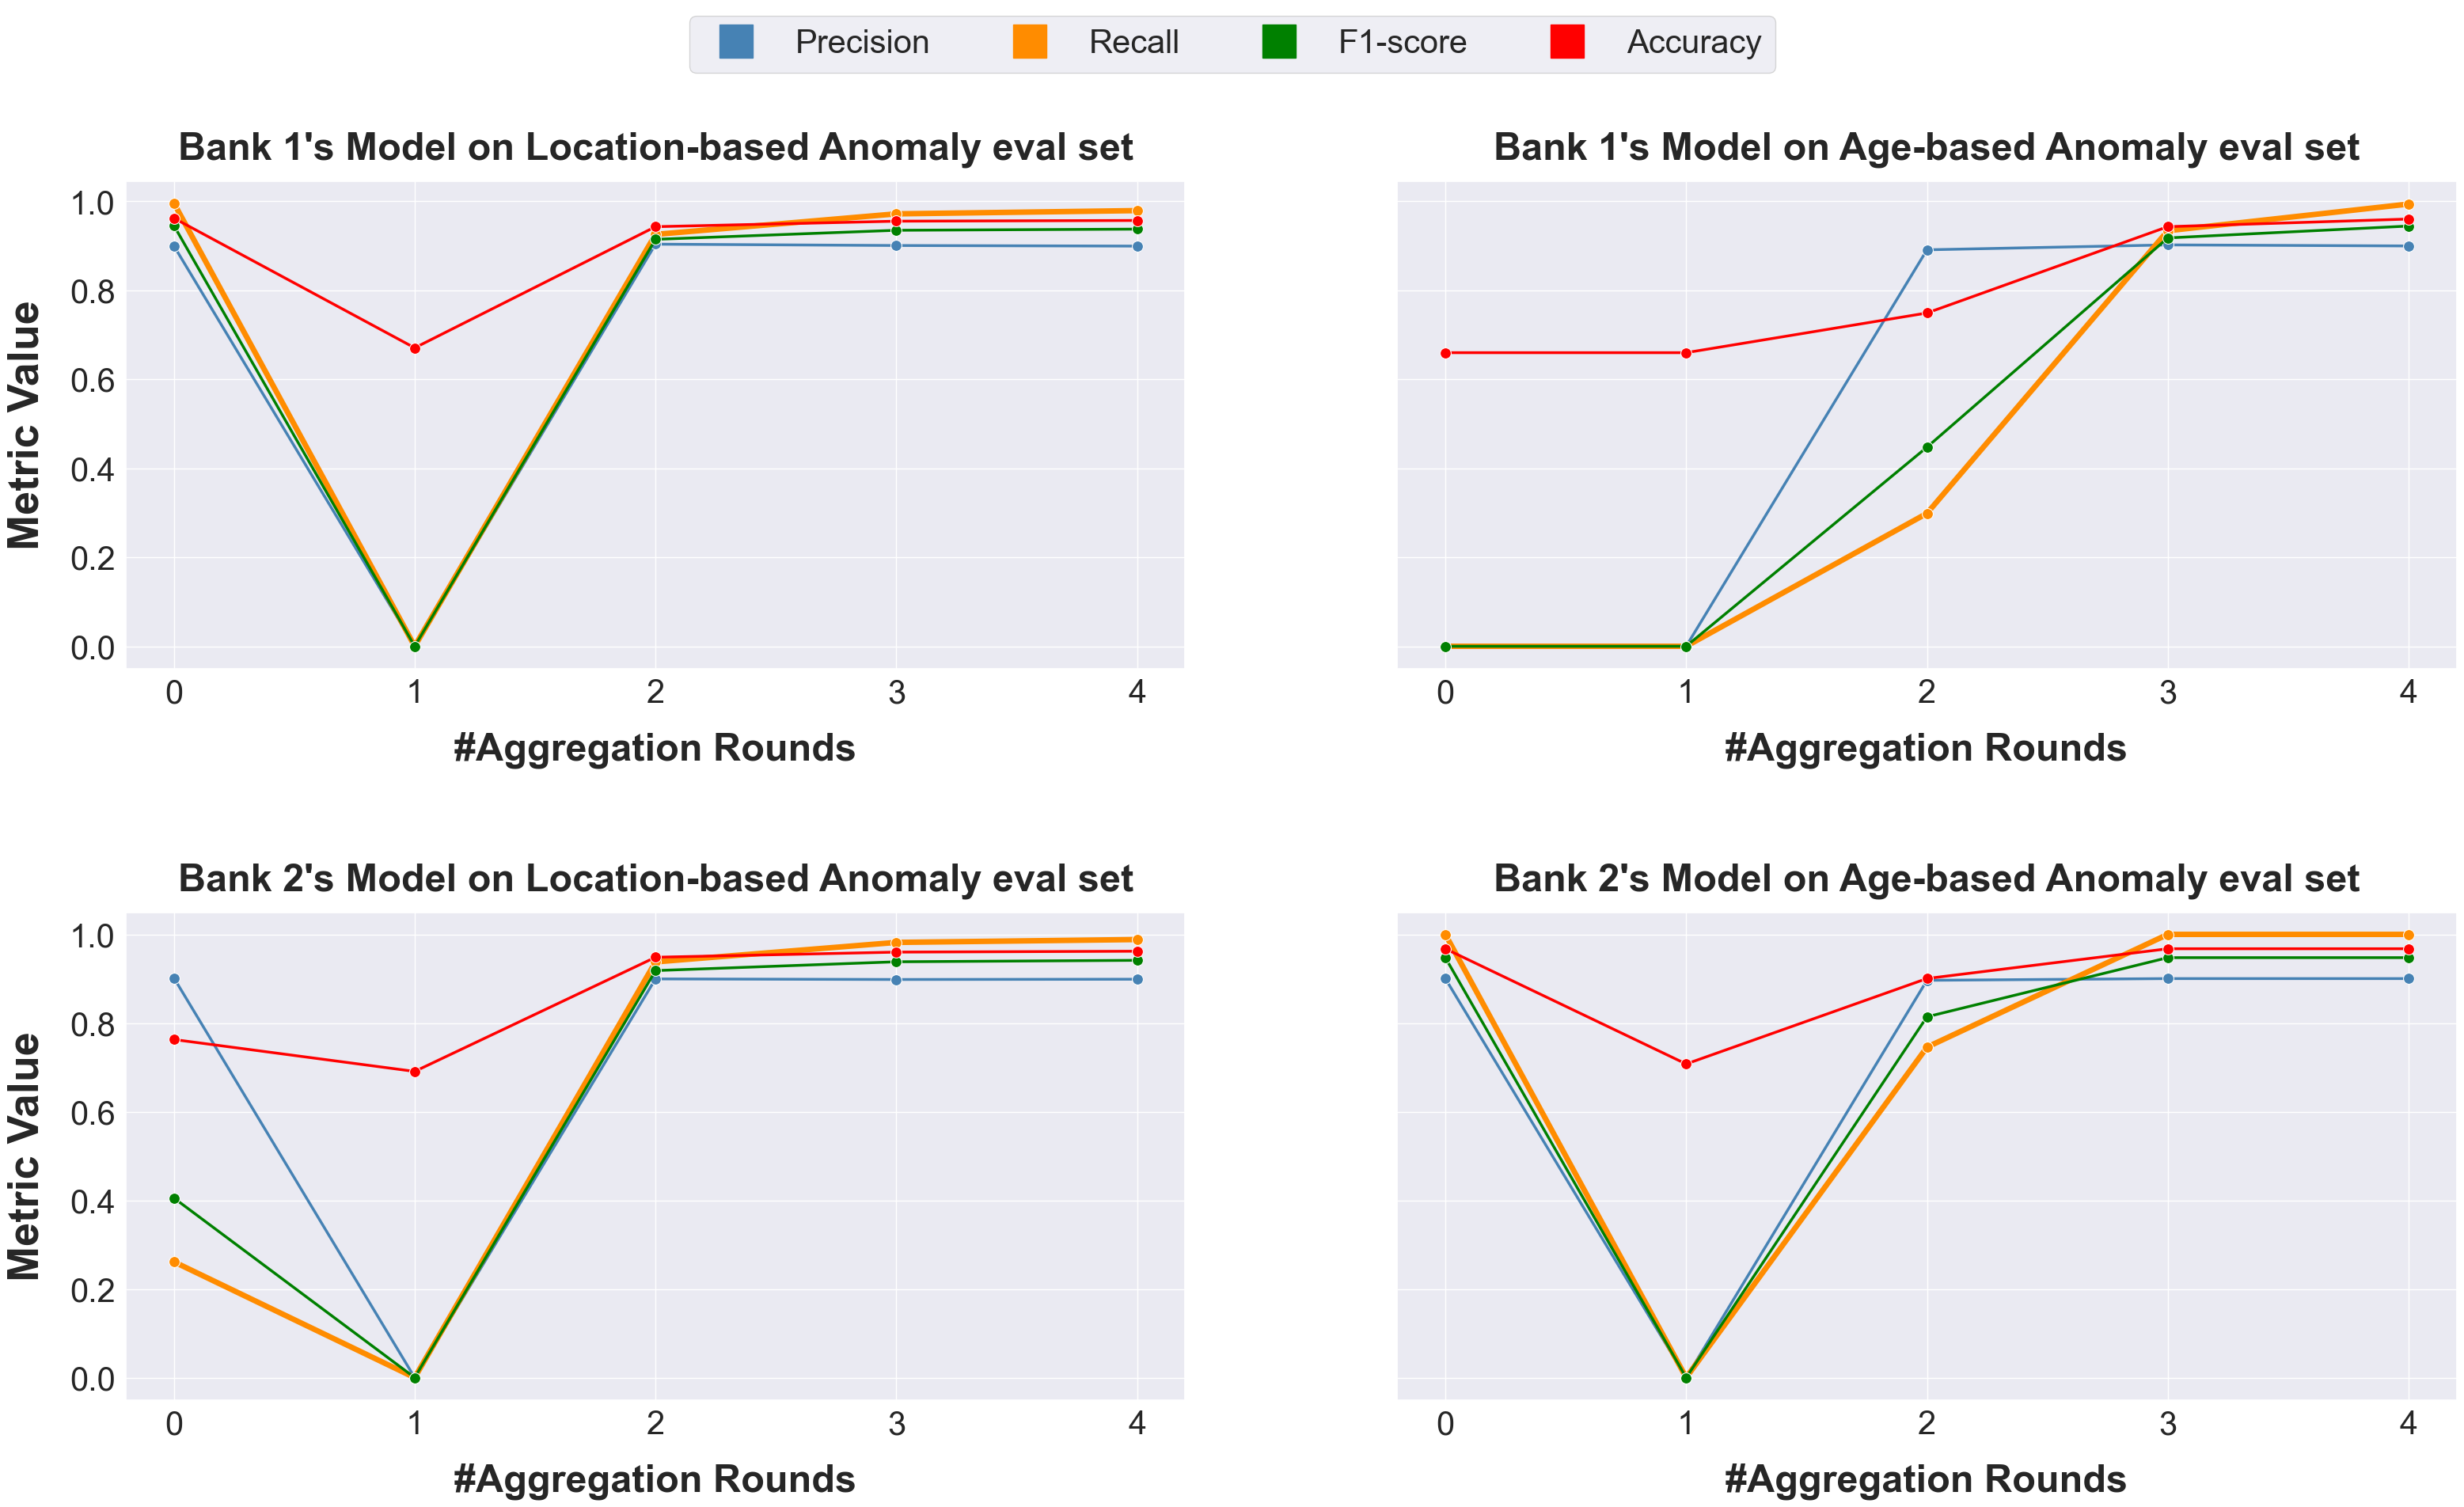

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=(38, 20), sharey="row")#, sharex="col")
axes = axes.flatten()
idx = 0

for i in ["bank1", "bank2"]:
    for j in ["type1", "type2"]:
        filtered_data = model_results[(model_results["bank"]==i) & (model_results["eval"]==j)]
        sns.lineplot(data=filtered_data, x="round", y="precision", markers=True, color = "steelblue",ax=axes[idx], linewidth=2.5, marker='o', markersize=10)
        sns.lineplot(data=filtered_data, x="round", y="recall", markers=True, color="darkorange",ax=axes[idx], linewidth=5, marker='o', markersize=10)
        sns.lineplot(data=filtered_data, x="round", y="f1", markers=True, color="green",ax=axes[idx], linewidth=2.5, marker='o', markersize=10)
        sns.lineplot(data=filtered_data, x="round", y="accuracy", markers=True, color="red",ax=axes[idx], linewidth=2.5, marker='o', markersize=10)
        
        
        axes[idx].set_title(label_map[i] + "'s Model on " + label_map[j] + " eval set", fontsize=35, pad=20, fontweight="bold")
        # axes[idx].set_xlabel(feat_label_map[feature], fontsize=24, labelpad=20)
        axes[idx].set_xlabel("#Aggregation Rounds", fontsize=35, labelpad=20, fontweight="bold")
        axes[idx].set_ylabel("Metric Value",fontsize=39, labelpad=20, fontweight="bold")
        axes[idx].set_xticks([0,1,2,3,4])
        # axes[idx].set_xticks(fontsize=12)  # Increase x-axis tick label font size
        # axes[idx].set_yticks(fontsize=12)
        axes[idx].tick_params(labelsize=30)
        idx += 1
# plt.tight_layout()

line1 = plt.plot([], [], "steelblue", marker='s',markersize=30, ls="none", label='Precision')[0]
line2 = plt.plot([], [], "darkorange",marker='s', markersize=30, ls="none", label='Recall')[0]
line3 = plt.plot([], [], "green",marker='s', markersize=30, ls="none", label='F1-score')[0]
line4 = plt.plot([], [], "red",marker='s', markersize=30, ls="none", label='Accuracy')[0]
fig.legend(handles=[line1, line2, line3, line4], loc="upper center", fontsize=30, ncol=4)

plt.subplots_adjust(hspace=0.5)

# plt.savefig("metrics.png")
plt.show()



# SHAP - Contribution of each feature in prediction 

In [33]:
import json

In [17]:
shap_data = glob.glob("/Users/V822540/Downloads/onyx/aikya-material-shared/results-raw-data/*shap*")

In [18]:
shap_data

['/Users/V822540/Downloads/onyx/aikya-material-shared/results-raw-data/bank1-type2-fedlearn_client_model_predict_shap_data.csv',
 '/Users/V822540/Downloads/onyx/aikya-material-shared/results-raw-data/bank2-type2-fedlearn_client_model_predict_shap_data.csv',
 '/Users/V822540/Downloads/onyx/aikya-material-shared/results-raw-data/bank2-type1-fedlearn_client_model_predict_shap_data.csv',
 '/Users/V822540/Downloads/onyx/aikya-material-shared/results-raw-data/bank1-type1-fedlearn_client_model_predict_shap_data.csv']

In [34]:
shap_results = []

for file in shap_data:
    shap_vals = pd.DataFrame([json.loads(i) for i in list(pd.read_csv(file)["shapley_values"])])
    metadata = file.split("/")[-1][:-4].split("-")
    shap_results.append({"bank": metadata[0],
                          "eval": metadata[1],
                          "data": shap_vals})

In [62]:
shap_results = sorted(shap_results, key=lambda d: (d['bank'],d["eval"]))

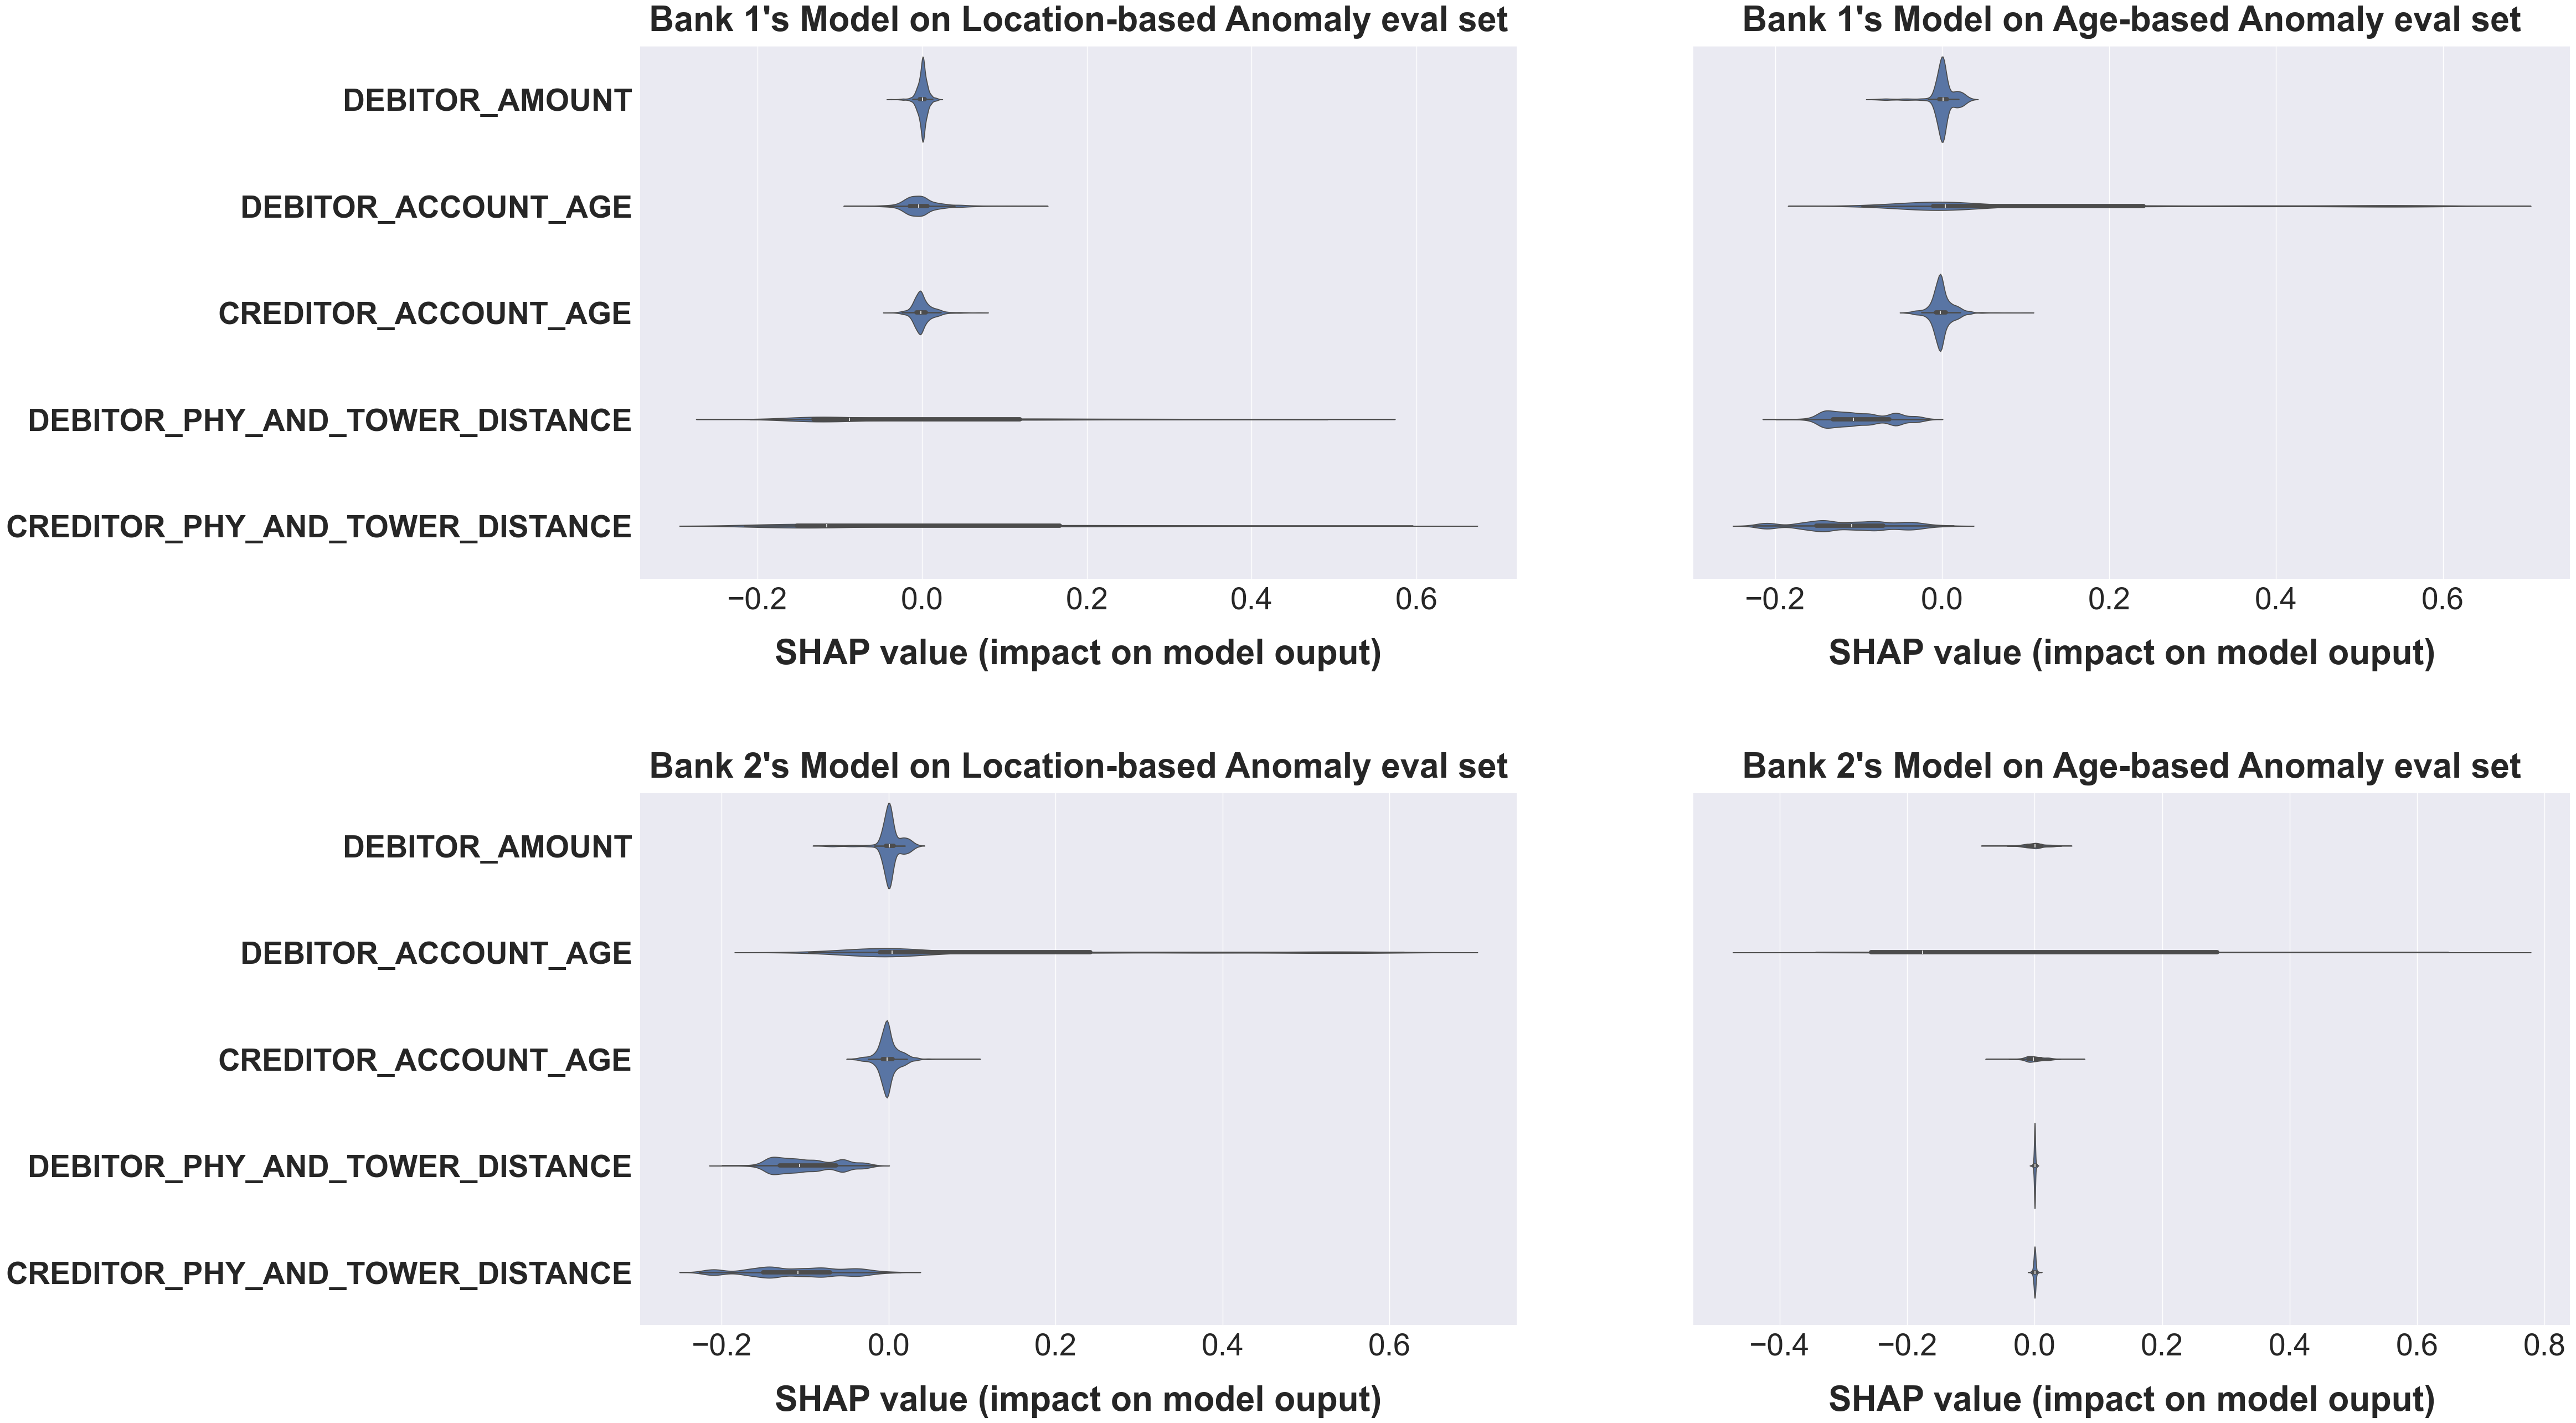

In [72]:

fig, axes = plt.subplots(ncols=2, nrows=2,figsize=(45, 30), sharey="row")#, sharex="col")
axes = axes.flatten()
idx = 0

for i in shap_results:

    # Load a sample dataset (e.g., the 'iris' dataset)
    df_melted = i["data"].melt(var_name='columns', value_name='values')
    
    # Create the horizontal violin plot
    sns.violinplot(y='columns', x='values', data=df_melted, ax=axes[idx])
    
    # Set the axis labels
    axes[idx].set_xlabel("SHAP value (impact on model ouput)", fontsize=45, fontweight="bold", labelpad=30)
    axes[idx].set_ylabel("", fontsize=24, labelpad=30)
    axes[idx].set_title(label_map[i["bank"]] + "'s Model on " + label_map[i["eval"]] + " eval set", fontsize=45, pad=20, fontweight="bold")
    axes[idx].tick_params(labelsize=40)
    for label in axes[idx].get_yticklabels():
       label.set_fontweight('bold')
    plt.subplots_adjust(hspace=0.4)#, wspace=0.1)
    
    idx += 1

# Show the plot
plt.savefig("shapley.png")

plt.show()